In [ ]:
# 🔥 Úplné odstránenie nekompatibilných verzií
!pip uninstall -y transformers huggingface-hub tokenizers sentence-transformers peft

# 🧹 (ak máš oprávnenie) Vyčistenie cache
!rm -rf /root/.cache/huggingface

# ✅ Inštalácia stabilných verzií, ktoré sú 100 % kompatibilné s Trainer
!pip install transformers==4.40.1 huggingface-hub==0.30.2 tokenizers==0.19.1


In [1]:
import transformers
print(transformers.__version__)


4.40.1


In [2]:
# 📦 Inštalácia potrebných knižníc
!pip install -q transformers datasets scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platfo

In [3]:
# 🧠 Import knižníc a inicializácia premenných
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
)
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, precision_recall_curve, auc, f1_score
)

torch.manual_seed(42)
np.random.seed(42)

training_losses = []
validation_losses = []
eval_accuracies = []
epochs_logged = []


2025-05-05 09:21:07.061441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746436867.259487      86 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746436867.315749      86 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# 📊 Výpočet presnosti, precision, recall a F1-score
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [6]:
# 🔁 Callback na zber tréningových a validačných strát po epoche
class EpochMetricsTracker(TrainerCallback):
    def __init__(self):
        self.last_logged_epoch = -1

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs and 'epoch' in logs:
            epoch = int(logs['epoch'])
            if epoch != self.last_logged_epoch:
                training_losses.append(logs['loss'])
                self.last_logged_epoch = epoch

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            if 'eval_loss' in metrics:
                validation_losses.append(metrics['eval_loss'])
            if 'eval_accuracy' in metrics:
                eval_accuracies.append(metrics['eval_accuracy'])
            epochs_logged.append(int(state.epoch))


In [7]:
# 📥 Načítanie a tokenizácia dát z TUKE-KEMT/hate_speech_slovak
print("📥 Nacitavam dataset TUKE-KEMT/hate_speech_slovak...")
dataset = load_dataset("TUKE-KEMT/hate_speech_slovak")
train_dataset = dataset['train']
test_dataset = dataset['test']

model_name = "gerulata/slovakbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


📥 Nacitavam dataset TUKE-KEMT/hate_speech_slovak...


README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

train.json:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/208k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11870 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/533k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/11870 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [8]:
# 🔥 Úprava modelu SlovakBERT s váhovaným lossom na lepšiu detekciu toxickej triedy
class SlovakBERTWeighted(nn.Module):
    def __init__(self, model_name, num_labels=2, pos_weight=None):
        super(SlovakBERTWeighted, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = None
        if labels is not None:
            labels_one_hot = nn.functional.one_hot(labels, num_classes=2).float()
            loss = self.loss_fn(logits, labels_one_hot)
        return {"loss": loss, "logits": logits}


In [9]:
# ⚖️ Výpočet váh pre triedy (toxická = menšina)
tox_count = sum([1 for x in train_dataset if x['label'] == 1])
non_tox_count = sum([1 for x in train_dataset if x['label'] == 0])
pos_weight = torch.tensor([non_tox_count / tox_count]).to("cuda" if torch.cuda.is_available() else "cpu")

# Inicializácia modelu s váhovaným lossom
model = SlovakBERTWeighted(model_name=model_name, pos_weight=pos_weight)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at gerulata/slovakbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# ⚙️ Nastavenie tréningových parametrov
output_dir = "./results_slovakbert"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    fp16=True
)


In [12]:
# 🏋️ Spustenie trénovania modelu s early stopping a sledovaním metriky F1
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EpochMetricsTracker(), EarlyStoppingCallback(early_stopping_patience=3)]
)

print("🚀 Spúšťam tréning...")
trainer.train()


🚀 Spúšťam tréning...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.728900,0.699031,0.805155,0.659443,0.591667,0.623719
2,0.678100,0.695763,0.799090,0.664360,0.533333,0.591680
3,0.607000,0.744884,0.789234,0.601485,0.675000,0.636126
4,0.547100,0.791375,0.791509,0.623188,0.597222,0.609929
5,0.527700,0.811410,0.798332,0.655629,0.550000,0.598187
6,0.413700,0.962379,0.796058,0.652174,0.541667,0.591806


TrainOutput(global_step=2226, training_loss=0.584932761265154, metrics={'train_runtime': 880.048, 'train_samples_per_second': 202.319, 'train_steps_per_second': 6.324, 'total_flos': 0.0, 'train_loss': 0.584932761265154, 'epoch': 6.0})

In [13]:
# 🎯 Návrh optimálneho prahu pre lepšiu rovnováhu medzi precision a recall
predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
labels = predictions.label_ids

thresholds = np.arange(0.3, 0.71, 0.01)
f1_scores = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"📌 Najlepší threshold: {best_threshold:.2f} (F1 = {f1_scores[best_idx]:.4f})")

final_preds = (probs >= best_threshold).astype(int)


📌 Najlepší threshold: 0.50 (F1 = 0.6361)


In [14]:
report = classification_report(
    labels,
    final_preds,
    target_names=["Netoxický", "Toxický"],
    digits=4,
    output_dict=True
)

# Textová verzia pre čitateľa
with open(f"{output_dir}/classification_report.txt", "w") as f:
    f.write(classification_report(labels, final_preds, target_names=["Netoxický", "Toxický"], digits=4))

# CSV verzia pre tabuľku do bakalárky
pd.DataFrame(report).transpose().to_csv(f"{output_dir}/classification_report_full.csv")

# Výpis do výstupu notebooku
import pprint
pprint.pprint(report)

# Konfúzna matica
cm = confusion_matrix(labels, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Netoxický", "Toxický"],
            yticklabels=["Netoxický", "Toxický"])
plt.title("Matica zámen – testovacie dáta (optimalizovaný threshold)")
plt.xlabel("Predikované")
plt.ylabel("Skutočné")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

{'Netoxický': {'f1-score': 0.8516542155816437,
               'precision': 0.8721311475409836,
               'recall': 0.8321167883211679,
               'support': 959},
 'Toxický': {'f1-score': 0.6361256544502617,
             'precision': 0.6014851485148515,
             'recall': 0.675,
             'support': 360},
 'accuracy': 0.7892342683851402,
 'macro avg': {'f1-score': 0.7438899350159527,
               'precision': 0.7368081480279176,
               'recall': 0.7535583941605839,
               'support': 1319},
 'weighted avg': {'f1-score': 0.792829134454049,
                  'precision': 0.7982626413625094,
                  'recall': 0.7892342683851402,
                  'support': 1319}}


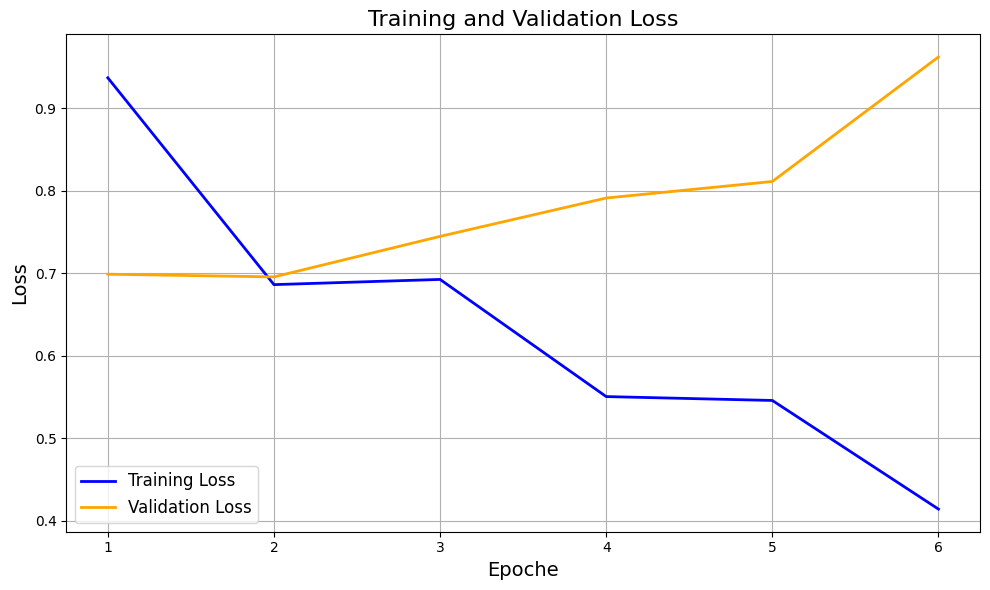

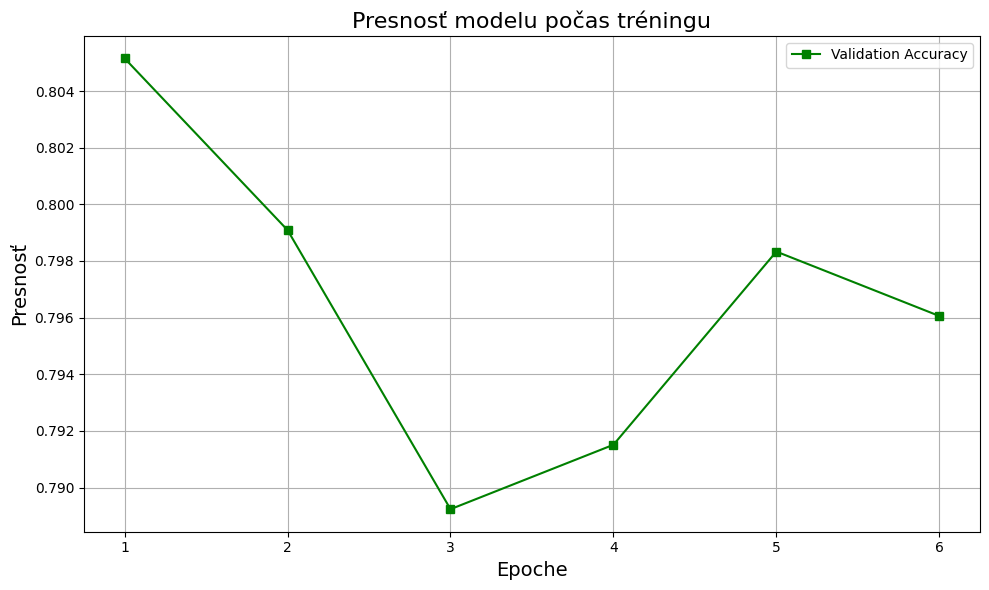

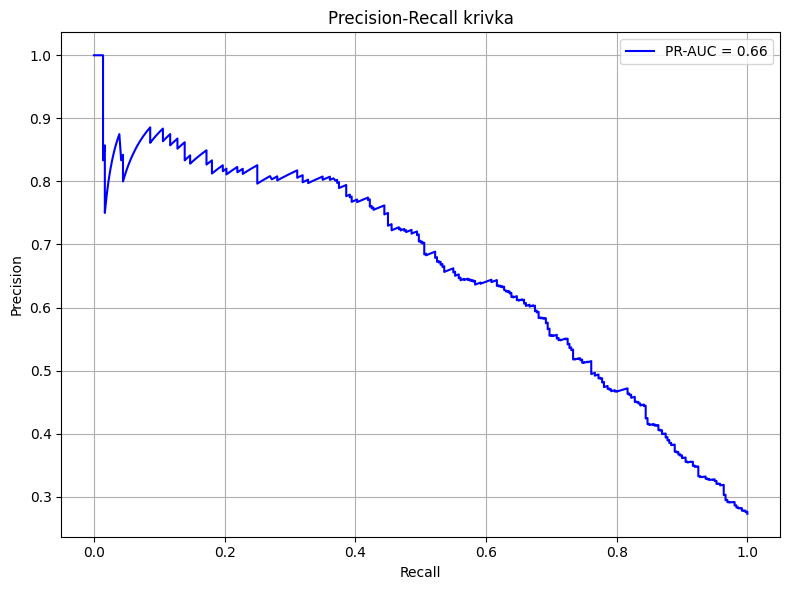

In [15]:
# 📈 Kreslenie grafov vhodných do práce – loss, accuracy a precision-recall krivka
min_len = min(len(training_losses), len(validation_losses), len(eval_accuracies))
epochs = list(range(1, min_len + 1))
train_loss_epoch = training_losses[:min_len]
val_loss_epoch = validation_losses[:min_len]
acc_epoch = eval_accuracies[:min_len]

# Loss graf
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label="Training Loss", color="blue", linewidth=2)
plt.plot(epochs, val_loss_epoch, label="Validation Loss", color="orange", linewidth=2)
plt.xlabel("Epoche", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training and Validation Loss", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/loss_clean_graph.png", dpi=300)
plt.show()

# Accuracy graf
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc_epoch, label="Validation Accuracy", marker='s', color="green")
plt.xlabel("Epoche", fontsize=14)
plt.ylabel("Presnosť", fontsize=14)
plt.title("Presnosť modelu počas tréningu", fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/accuracy_graph.png", dpi=300)
plt.show()

# Precision-Recall krivka
precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall krivka")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/precision_recall_curve.png", dpi=300)
plt.show()


In [16]:
# 💾 Export natrénovaného modelu a zazipovanie celej zložky výsledkov
trainer.save_model(f"{output_dir}/fine_tuned_model")
!zip -r /kaggle/working/results_slovakbert.zip {output_dir} > /dev/null


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
# 🔍 Spustenie predikcie modelu na testovacích dátach
preds_output = trainer.predict(test_dataset)

# Získame predikcie a pravé hodnoty
labels = preds_output.label_ids
final_preds = np.argmax(preds_output.predictions, axis=1)
probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()


In [18]:
# 📌 Výpočet doplňujúcich metrík – MCC, ROC AUC, PR AUC
from sklearn.metrics import matthews_corrcoef, roc_auc_score, precision_recall_curve, auc, roc_curve

# Predikcie z trainer.predict()
probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()
final_preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# MCC
mcc = matthews_corrcoef(labels, final_preds)
print("Matthews Correlation Coefficient (MCC):", round(mcc, 4))

# ROC AUC
roc_auc = roc_auc_score(labels, probs)
print("ROC AUC:", round(roc_auc, 4))

# PR AUC
precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)
print("PR AUC:", round(pr_auc, 4))


Matthews Correlation Coefficient (MCC): 0.4901
ROC AUC: 0.8125
PR AUC: 0.6594


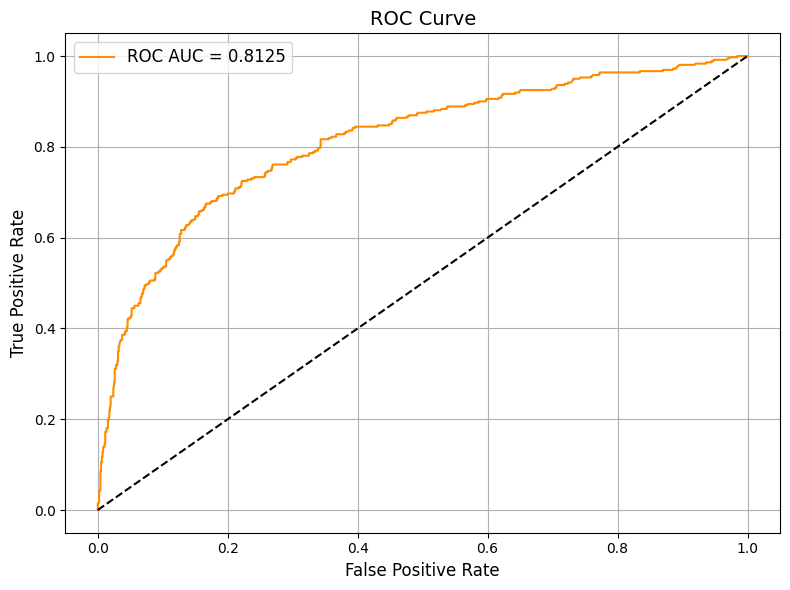

In [22]:
# 📈 ROC krivka – hodnotí schopnosť modelu rozlíšiť triedy
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(labels, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/roc_curve.png", dpi=300)
plt.show()


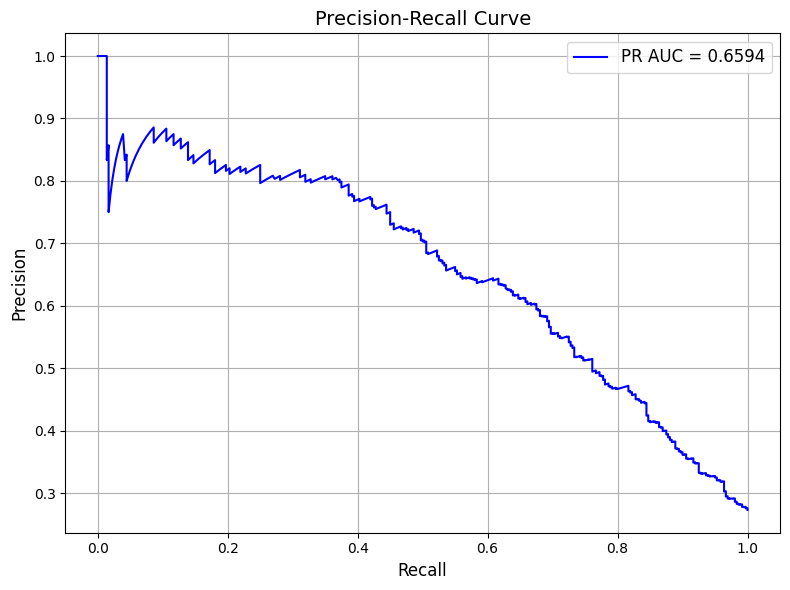

In [23]:
# 📈 Precision-Recall krivka – najmä pri nevyvážených dátach
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}", color="blue")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"{output_dir}/precision_recall_curve.png", dpi=300)
plt.show()


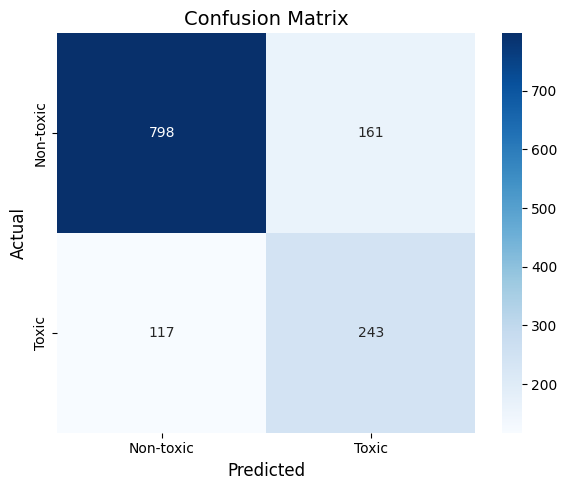

In [26]:
# 📊 Confusion Matrix – zobrazuje skutočné vs. predikované triedy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-toxic", "Toxic"],
            yticklabels=["Non-toxic", "Toxic"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png", dpi=300)
plt.show()


In [25]:
# 📄 Uloženie klasifikačného reportu aj ako TXT
from sklearn.metrics import classification_report

report_txt = classification_report(labels, final_preds, target_names=["Non-toxic", "Toxic"], digits=4)
with open(f"{output_dir}/classification_report.txt",  "w") as f:
    f.write(report_txt)


In [28]:
import zipfile
import os

output_zip = "slovakbert_results.zip"
results_dir = "results_slovakbert"

with zipfile.ZipFile(output_zip, "w") as zipf:
    for file in os.listdir(results_dir):
        if file.endswith(".png") or file.endswith(".csv") or file.endswith(".txt"):
            zipf.write(os.path.join(results_dir, file), arcname=file)

print(f"ZIP súbor vytvorený: {output_zip}")


ZIP súbor vytvorený: slovakbert_results.zip
